# Quantization of models

<a target="_blank" href="https://colab.research.google.com/github/toelt-llc/HSLU-WSCS_2025/blob/master/06%20-%20Quantization_of_models_Complete_examples.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(C) Umberto Michelucci

umberto.michelucci@toelt.ai

www.toelt.ai


In [1]:
# !pip3 uninstall tensorflow
# !pip3 install tf-nightly

In [2]:
#
# DON'T USE THE FOLLOWING MAGIC COMMAND IN CASE YOU ARE INSTALLING TF-NIGHTLY.
# IT WILL USE THE WRONG VERSION OF TENSORFLOW.
#
#try:
  # %tensorflow_version only exists in Colab.
  #%tensorflow_version 2.x
#except Exception:
#  pass


import tensorflow as tf

In [3]:
print(tf.__version__)

2.18.0


In [4]:
import sys
import os

if sys.version_info.major >= 3:
    import pathlib
else:
    import pathlib2 as pathlib

# Add `models` to the python path.
models_path = os.path.join(os.getcwd(), "models")
sys.path.append(models_path)

In [5]:
saved_models_root = "/tmp/mnist_saved_model"

#  Simple MNIST Model

## Fitting and saving the model

In [6]:
import tensorflow.keras as keras
import numpy as np

import matplotlib.pyplot as plt

We first import the `MNIST` dataset with the `tf.keras.datasets`. Note that we reshape the input into a `(60000, 784)` array.

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0
print(x_train.shape)

(60000, 28, 28)


We build a very dumb network with just one hidden layer with 128 neurons with `relu` activation functions. The output layer has 10 neurons (since we want to classify 10 classes) and then a `softmax` activation function.

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
         optimizer=keras.optimizers.Adam(),
         metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8811 - loss: 0.4226
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9634 - loss: 0.1232
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9759 - loss: 0.0815
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9827 - loss: 0.0588
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9871 - loss: 0.0449


The following cell will save the model. We will use this saved version in the next sections.

In [10]:
export_dir = "/tmp/mnist"
tf.saved_model.save(model, export_dir)

## Convert to a TensorFlow Lite model

Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), and apply varying degrees of quantization.

As a first step, we can simply convert the model without any quantization. Basically we simply change its format to `TFLite` but we will not change any weight.

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

Saved artifact at '/tmp/tmpdmp8ifmu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133735820989392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735821366032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735835042256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735821366224: TensorSpec(shape=(), dtype=tf.resource, name=None)


It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.

### Convert using float fallback quantization

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.)
To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.


In [12]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

Saved artifact at '/tmp/tmpfhe6zo1b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133735820989392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735821366032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735835042256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735821366224: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Now all weights and variable data are quantized, and the model is significantly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


That's usually good for compatibility, but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

Additionally, the above process may leave an operation in float format if TensorFlow Lite doesn't include a quantized implementation for that operation. This strategy allows conversion to complete so you have a smaller and more efficient model, but again, it won't be compatible with integer-only hardware. (All ops in this MNIST model have a quantized implementation.)

So to ensure an end-to-end integer-only model, you need a couple more parameters...

### Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [14]:
# need representative data generator again
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

Saved artifact at '/tmp/tmp5we0d6bq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133735820989392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735821366032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735835042256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133735821366224: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [15]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai).

### Save the models as files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [16]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

108136

## Run the TensorFlow Lite models

Now we'll run inferences using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:


In [17]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global x_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    x_test_image = x_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      x_test_image = x_test_image / input_scale + input_zero_point

    x_test_image = np.expand_dims(x_test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], x_test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


### Test the models on one image


Now we'll compare the performance of the float model and quantized model:
+ `tflite_model_file` is the original TensorFlow Lite model with floating-point data.
+ `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:

In [18]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global y_test

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(x_test[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(y_test[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

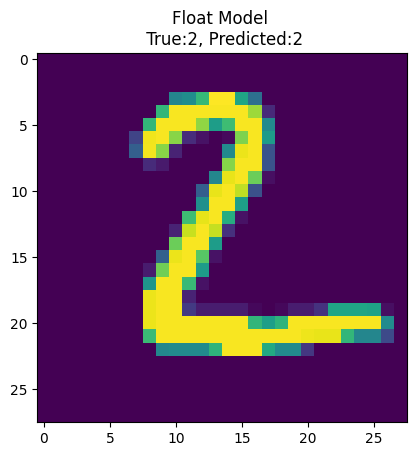

In [19]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:

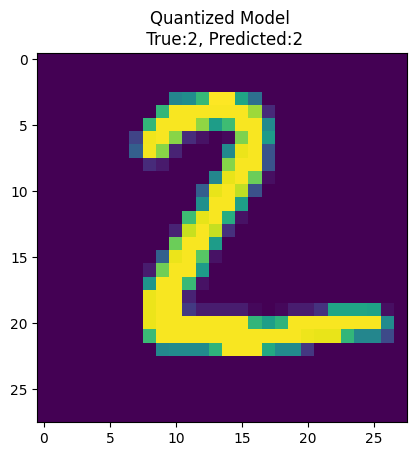

In [20]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluate the models on all images

Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [21]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global x_test
  global y_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(y_test== predictions) * 100) / len(x_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_test)))

Evaluate the float model:

In [22]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 97.7000% (Number of test samples=10000)


Evaluate the quantized model:

In [23]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 97.6700% (Number of test samples=10000)


So you now have an integer quantized a model with almost no difference in the accuracy, compared to the float model.

To learn more about other quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).